# Recurrent Neural Networks

All the models we have discussed so far were looking at the inputs as isolated instances. In image classification we determine the category of and image, in semantic segmentation we produce a semantic map from the input. But there are many cases were datapoints are not isolated instances and have connection to each other. Sequential data are the type of data where each instance is related to the instances came before. A good example for this type of data is time series data. At each point in time to the value of the time series depends on the value of the prior points. Recurrent Neural Networks (RNN) are a class of networks which deal with sequential data. There are many variants of Recurrent Neural Networks, including:

- Simple Recurrect Neural Networks (Simple RNN - or often just called RNN)
- Long Short-Term Memory (LSTM)
- Gated Recurrent Unit (GRU)

In this notebook we will discuss LSTM; however, the general logic behind all these methods are the same. They only differ in the way they handel information internally. 
<img src='./images/RNN.png'>
<div style="font-size:70%">Recurrent Neural Networks Architecture - Credit to <a href='https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0180944'>Bao et al.</a></div>
At each step a set of values are stored as state of the model ($s$). The state is updated at each step and based on the value of the state the output of the model is calculated by passing state through the output layer ($V$). Also, the model takes an input $x_t$ and passes it through an input layer ($U$), The output of this layer is combined with the state of previous step and creates the new state ($s_t$). What is important here is that the input and output layers are the same for all the sequences of data. What makes the output different at each step are the input values and state of the model. <br>
Various architectures handel updating the state value differently and this is the main difference between Simple RNN, LSTM, and GRU. 

In [1]:
import torch
from torch import nn, optim
from torch import functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import xarray as xr

In [2]:
# TODO use just seq(LSTM, linear)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
#         self.linear = nn.Linear(hidden_size * num_layers, output_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        device = next(iter(self.parameters())).device
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        output, (h_n, c_n) = self.lstm(x, (h_0, c_0))
#         h_n = h_n.view(-1, self.num_layers * self.hidden_size)
        seq_len = x.shape[1]
        h_n = output.view(-1, seq_len, self.hidden_size)[:, -1]
        out = self.linear(h_n)
        return out

## Classification
So far we tried single and multivariate time series using LSTM. But LSTMs are very flexible and useful for wide range of problems. For instance, we can have multi input and single output, or use a series to predict an entire different series. We can also use LSTM for classification of time series. What makes LSTM (or other types of Recurrecnt Neural Networks) interesting is that they are not just useful for time series. They can be used for any data that has sequence of values. For instance, they can be used for text prediction. If we map every word to a number then you can turn a text into a series of numbers then LSTM can be used for predicting the next word.


In this example we are going to look at well logs which are sequential data as well.

In [3]:
import pandas as pd
import xarray as xr
xf = xr.open_zarr("../../data/processed/geolink_norge_dataset/geolink_norge_well_logs.zarr")
# xf = xf.where(xf['Well'].str.startswith('30')).dropna(dim='Well', how='all')
df = xf.to_dataframe(dim_order=['Well', 'DEPT'])
df['LITHOLOGY_GEOLINK'] = df['LITHOLOGY_GEOLINK'].astype('category')
df['Well'] = df.index.get_level_values(0).astype('category')
df['DEPT'] = df.index.get_level_values(1)
feature_cols = ['CALI', 'DTC', 'GR', 'RDEP', 'RHOB',
       'RMED', 'xc', 'yc', 'DEPT']
df = df.dropna(how='any', subset=feature_cols+['LITHOLOGY_GEOLINK'])
df = df.sort_index()
df

CALI         DTC        Depth         GR  \
Well    DEPT                                                     
15_9-12 2215.80  14.438001  134.253601  2215.917725  60.285748   
        2215.95  14.438001  134.253601  2215.917725  60.285748   
        2216.10  14.633000  129.101868  2216.070068  63.250000   
        2216.25  14.813001  122.476944  2216.222412  61.405998   
        2216.40  14.383001  116.908607  2216.375000  62.561596   
...                    ...         ...          ...        ...   
7_3-1   4569.30   8.540000   63.450794  4569.305664  51.219002   
        4569.45   8.548000   63.590557  4569.458008  51.671001   
        4569.60   8.552000   64.036644  4569.610352  51.820999   
        4569.75   8.546000   64.322495  4569.762695  51.327999   
        4569.90   8.546000   64.322495  4569.762695  51.327999   

                LITHOLOGY_GEOLINK      RDEP      RHOB      RMED  split  \
Well    DEPT                                                             
15_9-12 2215.80        Shaly Silt  0.737006  2.363000  0.785088  train   
        2215.95        Shaly Silt  0.737006  2.363000  0.785088  train   
        2216.10        Shaly Silt  0.741000  2.340000  0.840000  train   
        2216.25        Shaly Silt  0.752000  2.314000  0.858000  train   
        2216.40        Shaly Silt  0.739962  2.293000  0.857046  train   
...                           ...       ...       ...       ...    ...   
7_3-1   4569.30  Cross Bedded Sst  6.639000  2.631049  6.690000  train   
        4569.45  Cross Bedded Sst  6.551000  2.626054  6.520000  train   
        4569.60  Cross Bedded Sst  6.464000  2.624065  6.462185  train   
        4569.75  Cross Bedded Sst  6.423000  2.636137  6.439074  train   
        4569.90  Cross Bedded Sst  6.423000  2.636137  6.439074  train   

                   wlbCompletionDate  wlbCompletionYear  \
Well    DEPT                                              
15_9-12 2215.80  1982-02-27T00:00:00               1982   
        2215.95  1982-02-27T00:00:00               1982   
        2216.10  1982-02-27T00:00:00               1982   
        2216.25  1982-02-27T00:00:00               1982   
        2216.40  1982-02-27T00:00:00               1982   
...                              ...                ...   
7_3-1   4569.30  1969-10-06T00:00:00               1969   
        4569.45  1969-10-06T00:00:00               1969   
        4569.60  1969-10-06T00:00:00               1969   
        4569.75  1969-10-06T00:00:00               1969   
        4569.90  1969-10-06T00:00:00               1969   

                 wlbKellyBushElevation  wlbTotalDepth        xc         yc  \
Well    DEPT                                                                 
15_9-12 2215.80                   25.0         3740.0  1.717781  58.456436   
        2215.95                   25.0         3740.0  1.717781  58.456436   
        2216.10                   25.0         3740.0  1.717781  58.456436   
        2216.25                   25.0         3740.0  1.717781  58.456436   
        2216.40                   25.0         3740.0  1.717781  58.456436   
...                                ...            ...       ...        ...   
7_3-1   4569.30                   31.0         4700.0  2.748781  57.843125   
        4569.45                   31.0         4700.0  2.748781  57.843125   
        4569.60                   31.0         4700.0  2.748781  57.843125   
        4569.75                   31.0         4700.0  2.748781  57.843125   
        4569.90                   31.0         4700.0  2.748781  57.843125   

                    Well     DEPT  
Well    DEPT                       
15_9-12 2215.80  15_9-12  2215.80  
        2215.95  15_9-12  2215.95  
        2216.10  15_9-12  2216.10  
        2216.25  15_9-12  2216.25  
        2216.40  15_9-12  2216.40  
...                  ...      ...  
7_3-1   4569.30    7_3-1  4569.30  
        4569.45    7_3-1  4569.45  
        4569.60    7_3-1  4569.60  
        4569.75    7_

In [4]:
# 29, 30, 31, 35 are valid groups
# c=df['Well'].value_counts()
# c[c>10000].sort_index()


In [5]:
# We  will stick to a gorup of long wells 29, 30, 31, 35 are valid groups
# df=df[df['Well'].str.startswith('30')]
counts = df['Well'].value_counts()
counts[counts>0]

35_3-1       23767
35_4-1       23599
30_4-1       23291
31_4-3       21797
31_6-1       20466
             ...  
7_1-2 S       1552
33_9-17       1399
34_5-1 A      1343
16_11-1 S      172
16_7-1          35
Name: Well, Length: 183, dtype: int64

In [6]:
# # Let take the top 12 lithologies, replacing the rest with "rare"
# # print(len(df))
# removed_labels = df["LITHOLOGY_GEOLINK"].value_counts()[12:].index
# print(df['LITHOLOGY_GEOLINK'].value_counts())
# print('removed_labels', removed_labels)
# l = df["LITHOLOGY_GEOLINK"].values.remove_categories(removed_labels)
# df['LITHOLOGY_GEOLINK']  = l.add_categories('rare').fillna('rare')
# df['LITHOLOGY_GEOLINK'].value_counts()

In [7]:
removed_labels = list(df["LITHOLOGY_GEOLINK"].value_counts()[12:].keys())
i = df["LITHOLOGY_GEOLINK"].values.remove_categories(removed_labels)
i[i.isna()]

[NaN, NaN, NaN, NaN, NaN, ..., NaN, NaN, NaN, NaN, NaN]
Length: 40017
Categories (12, object): ['Argillaceous Limestone', 'Calcareous Cement', 'Cinerite', 'Cross Bedded Sst', ..., 'Shaly Silt', 'Silt', 'Silty Sand', 'Silty Shale']

In [8]:
df["LITHOLOGY_GEOLINK"].values

['Shaly Silt', 'Shaly Silt', 'Shaly Silt', 'Shaly Silt', 'Shaly Silt', ..., 'Cross Bedded Sst', 'Cross Bedded Sst', 'Cross Bedded Sst', 'Cross Bedded Sst', 'Cross Bedded Sst']
Length: 1303869
Categories (22, object): ['', 'Anhydrite', 'Argillaceous Limestone', 'Calcareous Cement', ..., 'Shaly Silt', 'Silt', 'Silty Sand', 'Silty Shale']

In [9]:
l = df['LITHOLOGY_GEOLINK']
l[l.isna()]

Series([], Name: LITHOLOGY_GEOLINK, dtype: category
Categories (22, object): ['', 'Anhydrite', 'Argillaceous Limestone', 'Calcareous Cement', ..., 'Shaly Silt', 'Silt', 'Silty Sand', 'Silty Shale'])

In [10]:
# Remove unused categories, and order
df['LITHOLOGY_GEOLINK'] = df['LITHOLOGY_GEOLINK'].values.remove_unused_categories()

# sort categories (leads to nicer histograms)
i = df['LITHOLOGY_GEOLINK'].values
litho_sorted = i.value_counts().sort_values(ascending=True).index
df['LITHOLOGY_GEOLINK'] = i.reorder_categories(list(litho_sorted), ordered=True)

df['LITHOLOGY_GEOLINK'].values.categories

Index(['Carnallite', 'Gap', 'Conglomerate', 'Halite', 'Anhydrite', 'Dolomite',
       'Coal', 'Porous Limestone', 'Chalk', 'Calcareous Cement', 'Cinerite',
       'Sandstone', 'Sandy Silt', 'Argillaceous Limestone', 'Limestone',
       'Cross Bedded Sst', 'Silty Sand', 'Silty Shale', 'Marlstone',
       'Shaly Silt', 'Silt'],
      dtype='object')

Silt                      313648
Shaly Silt                296557
Marlstone                 145779
Silty Shale                98688
Silty Sand                 91266
Cross Bedded Sst           76440
Limestone                  55532
Argillaceous Limestone     50595
Sandy Silt                 45852
Sandstone                  37146
Cinerite                   29525
Calcareous Cement          22824
Chalk                      16201
Porous Limestone           10185
Coal                        5076
Dolomite                    3070
Anhydrite                   2464
Halite                      1033
Conglomerate                1030
Gap                          742
Carnallite                   216
Name: LITHOLOGY_GEOLINK, dtype: int64

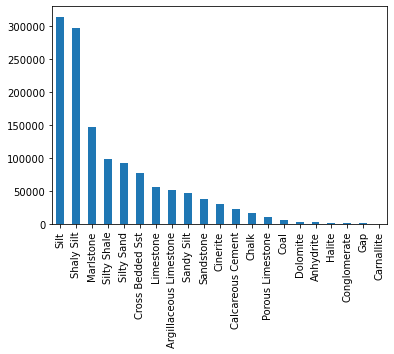

In [11]:
df['LITHOLOGY_GEOLINK'].value_counts().plot.bar()
df['LITHOLOGY_GEOLINK'].value_counts()

In [12]:
# Add a well int, so the model will know what well we use
well_index = df['Well'].values
well_int = well_index.rename_categories(range(len(well_index.categories))).astype(int)
df['Well_int']= well_int
df[['Well_int']]

Well_int
Well    DEPT             
15_9-12 2215.80         0
        2215.95         0
        2216.10         0
        2216.25         0
        2216.40         0
...                   ...
7_3-1   4569.30       182
        4569.45       182
        4569.60       182
        4569.75       182
        4569.90       182

[1303869 rows x 1 columns]

1

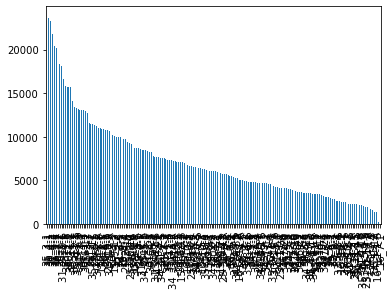

In [13]:
# Get a list of wells, ordered by frequency
well_counts = df['Well'].value_counts()
well_counts = well_counts[well_counts>0]
wells = list(well_counts.index)
well_counts.plot.bar()
1
# well_counts

In [14]:
# Select the N longest well logs
n_wells = min(len(wells), 200)
selected_wells = wells[:n_wells]
df = df.loc[selected_wells]
# df

1

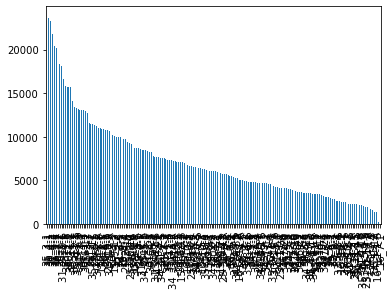

In [15]:
# Get a list of wells, ordered by frequency
well_counts = df['Well'].value_counts()
well_counts = well_counts[well_counts>0]
wells = list(well_counts.index)
well_counts.plot.bar()
1
# well_counts

In [16]:
shift_length = 20
print(f'model can see human labels up to {shift_length*0.15}m above')
df['LITH_ABV'] = df["LITHOLOGY_GEOLINK"].shift(shift_length).fillna('Shaly Silt')
df['LITH_ABV_INT'] = df['LITH_ABV'].values.codes
df[['LITHOLOGY_GEOLINK', 'LITH_ABV']]

model can see human labels up to 3.0m above


LITHOLOGY_GEOLINK    LITH_ABV
Well   DEPT                                 
35_3-1 887.10          Sandstone  Shaly Silt
       887.25          Sandstone  Shaly Silt
       887.40          Sandstone  Shaly Silt
       887.55          Sandstone  Shaly Silt
       887.70          Sandstone  Shaly Silt
...                          ...         ...
16_7-1 1449.45              Silt  Sandy Silt
       1449.60              Silt  Sandy Silt
       1449.75              Silt  Sandy Silt
       1449.90              Silt  Sandy Silt
       1450.05              Silt  Sandy Silt

[1303869 rows x 2 columns]

In [17]:
# SPLIT: We will train on measurements above Xkm depth, and test on deeper ones
from functools import partial

def get_depth_thresh(x, even_bottom=True):
    """
    On even number well codes take the bottom of the well for trainin
    """
    if len(x)==0: return x
    
    # if the well code is even take the top 
    code_is_even = (x['Well'].values.codes[0]%2)==0
    if code_is_even:
        even_bottom = not even_bottom
    
    d = x['DEPT']
    thresh = np.round(d.mean())
    x['thresh'] = thresh
    if even_bottom:
        return x[d>thresh]
    else:
        return x[d<thresh]


df_test = df.groupby(level=0).apply(partial(get_depth_thresh, even_bottom=False))
df_train = df.groupby(level=0).apply(partial(get_depth_thresh, even_bottom=True))
print('train', df_train.shape, 'test', df_test.shape)
print(f'Train {len(df_train)/len(df):.0%}, test {len(df_test)/len(df):.0%}')

train (649077, 21) test (654729, 21)
Train 50%, test 50%


In [18]:
train = []
test = []
for i, well in enumerate(selected_wells):
    df_well = df.loc[well]
    df_well.name = well
    i_halfway = int(len(df_well)*0.5)
    df_top = df_well.iloc[:i_halfway]
    df_bottom = df_well.iloc[i_halfway:]
    if i%2==0:
        train.append(df_top)
        test.append(df_bottom)
    else:
        train.append(df_bottom)
        test.append(df_top)
        
df_test = pd.concat(test).set_index(['Well', 'DEPT'], drop=False)
df_train = pd.concat(train).set_index(['Well', 'DEPT'], drop=False)
print('train', df_train.shape, 'test', df_test.shape)
print(f'Train {len(df_train)/len(df):.0%}, test {len(df_test)/len(df):.0%}')

train (651933, 20) test (651936, 20)
Train 50%, test 50%


In [19]:
a=set(df_train.index)
b=set(df_test.index)
assert len(a.intersection(b))==0

We will be using depth and other measurements to determine the lithology. We dealt with the same problem in the tablular data. But in tabular data we only look at the measurements at each depth to find the class, while here we can look at the variations in the measurements as well.

And add depth as a feature column:

As usual we need to create a training and test set. here we will only use `15` wells for training and `15` for testing as using the entire dataset means we need to spend much longer time for training.

We need to process the input and target data. The input data needs to be normalised with a standard scaler, and the output data needs to be converted from text to numbers. To convert text to numbers we use `LabelEncoder` from Scikit Learn.

In [20]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()

# Make a encoder, that order by frequency
encoder = LabelEncoder()

# TODO need to embed prev val..., one hot, then append
encoder.classes_ = df["LITHOLOGY_GEOLINK"].values.categories # np.array(counts.index.values)
print(encoder.classes_)
# feat_cols = ["CALI", "RHOB", "GR", "DTC", "RDEP", "RMED", "DEPT", "Well_int", "LITH_ABV_INT"]
feat_cols = feature_cols = ['CALI', 'DTC', 'GR', 'RDEP', 'RHOB', 'RMED', 'xc', 'yc', 'DEPT', "LITH_ABV_INT"]
scaler.fit(df[feat_cols].values)

Index(['Carnallite', 'Gap', 'Conglomerate', 'Halite', 'Anhydrite', 'Dolomite',
       'Coal', 'Porous Limestone', 'Chalk', 'Calcareous Cement', 'Cinerite',
       'Sandstone', 'Sandy Silt', 'Argillaceous Limestone', 'Limestone',
       'Cross Bedded Sst', 'Silty Sand', 'Silty Shale', 'Marlstone',
       'Shaly Silt', 'Silt'],
      dtype='object')


StandardScaler()

`LabelEncoder` converts each type to a value.

In [21]:
encoder.transform(["Shaly Silt"])

array([16])

Now we can check the types at various depths:

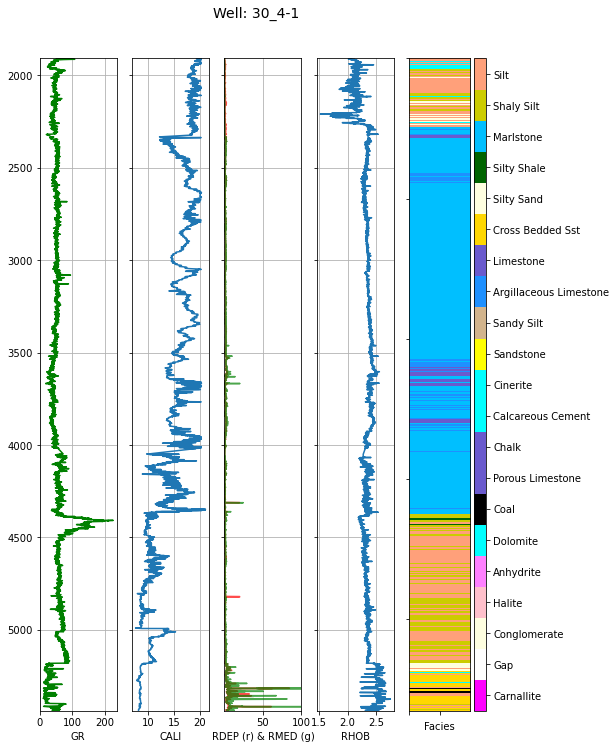

In [22]:
from deep_ml_curriculum.visualization.well_log import plot_facies, plot_well
well_name = "30_4-1"
logs = df.loc[well_name]
plot_well(
    well_name, 
    logs, 
    facies=logs['LITHOLOGY_GEOLINK'].astype('category').values
)

The output of a classification model is a value for each type. The type with the highest value is the one the model thinks is most likely to be associated with the input data. Therefore, the output size of the model should be the number of types.

Let's create training and test set, similar to what we had in multivariate time series. The only difference is here for each sequence of values we want the model to predict a value for each type.

In [23]:



def get_sequences(df, seq_length = 10):
    """Take moving sequences of a dataframe"""
    

    x = []
    y = []
    features = scaler.transform(df.loc[:, feat_cols].values)
    targets = encoder.transform(df.loc[:, "LITHOLOGY_GEOLINK"])

    # Add prev labels, as one hot, to inputs
    one_hot_targets = np.eye(len(encoder.classes_))[targets]
    prev_one_host_targets = np.roll(one_hot_targets, shift=shift_length)
    features = np.concatenate([features, prev_one_host_targets], 1)

    for i in range(len(targets) - seq_length):
        xi = features[i : i + seq_length, :]
        yi = targets[i + seq_length - 1]
        x.append(xi)
        y.append(yi)
    return x, y

# Note we give it prev lithology from 20:10 steps above
# And logs from 20:0 steps above
seq_length = 400
x_train, y_train = get_sequences(df_train, seq_length=seq_length)
x_test, y_test = get_sequences(df_test, seq_length=seq_length)
f'context length of {0.15*seq_length} m'

'context length of 60.0 m'

In [24]:
output_size = len(df["LITHOLOGY_GEOLINK"].unique())

It is important that we make sure the training and test set have close distribution. For instance, if there is a certain type in test data that doesn't exist in training data, the model will not be able to predict it.

In [25]:
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        x = x.cpu().detach().numpy()
    return x

def show_distribution(y, label):
    y = to_numpy(y)
    plt.hist(y, output_size * 2, alpha=0.5, label=label)
    plt.xticks(ticks=range(len(encoder.classes_)), labels=encoder.classes_, rotation=90)

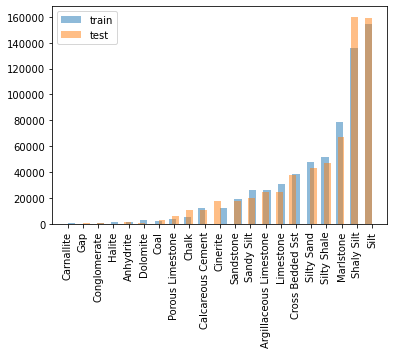

In [26]:
show_distribution(y_train, 'train')
show_distribution(y_test, 'test')
plt.legend()
plt.show()

In [159]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# x_train = torch.Tensor(x_train).float()#.to(device)
# y_train = torch.LongTensor(y_train)#.to(device)
# x_test = torch.Tensor(x_test).float()#.to(device)
# y_test = torch.LongTensor(y_test)#.to(device)
# x_train.shape, y_train.shape, x_test.shape, device

We can still use the same class for the model. Here the input size is the number of features we are using to predict the type, and output size is the number of types. 

1

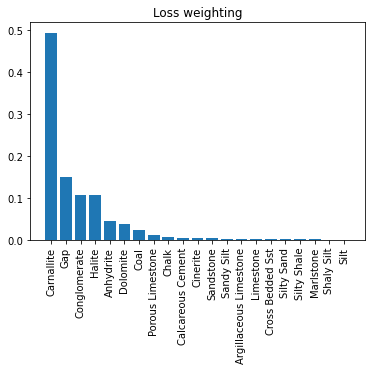

In [160]:
codes = df['LITHOLOGY_GEOLINK'].values.codes
unique, counts = np.unique(codes, return_counts=True)
weight = torch.from_numpy(1/(1e1+counts))
weight /= weight.sum()
# weight = None
weight

plt.title('Loss weighting')
# plt.bar(x=range(len(weight)), height=weight)
plt.bar(encoder.inverse_transform(unique), weight)
plt.xticks(rotation=90)
1

In [161]:
from sklearn.metrics import accuracy_score, f1_score

In [162]:
import torch
import torch.utils.data


class NumpyDataset(torch.utils.data.Dataset):
    """Dataset wrapping arrays.
    Each sample will be retrieved by indexing array along the first dimension.
    Arguments:
        *arrays (numpy.array): arrays that have the same size of the first dimension.
    """

    def __init__(self, *arrays):
        self.arrays = arrays

    def __getitem__(self, index):
        return tuple(array[index] for array in self.arrays)

    def __len__(self):
        return len(self.arrays[0])
dset_train = NumpyDataset(x_train, y_train)
load_train = torch.utils.data.dataloader.DataLoader(dset_train, batch_size=10, pin_memory=True, shuffle=True)
# next(iter(load_train))

In [163]:
score_fn=accuracy_score

def training_loop(epochs=1, bs=128, max_epoch_iters=256*128):
    all_losses = []
    all_accuracys = []
    try:
        for epoch in tqdm(range(epochs), desc='epochs'):
            model.train()
            
            training_loss = []
            training_accuracy = []
            
            dset_train = NumpyDataset(x_train, y_train)
            train_set_samplers=np.random.choice(list(range(len(dset_train))), max_epoch_iters)
            load_train = torch.utils.data.dataloader.DataLoader(
                dset_train, 
                batch_size=bs, pin_memory=True,# shuffle=True,
                sampler=train_set_samplers
            )
            
            for x, y in tqdm(load_train, leave=False, desc='train'):
                x = x.float().to(device)
                y = y.long().to(device)
                
                optimizer.zero_grad()
                preds = model(x)
                loss = loss_func(preds, y)
                loss.backward()
                optimizer.step()
                
                training_loss.append(loss.item())
                accuracy = score_fn(
                    to_numpy(y), to_numpy(preds).argmax(-1)
                )
                training_accuracy.append(accuracy)
            print(f"Epoch {epoch+1}/{epochs}: Training Loss = {np.mean(training_loss):.2f}, accuracy = {np.mean(accuracy):.3f}")

            model.eval()
            test_loss = []
            test_accuracy = []
            
            dset_test = NumpyDataset(x_test[:max_epoch_iters], y_test[:max_epoch_iters])
            load_test = torch.utils.data.dataloader.DataLoader(dset_test, batch_size=bs, pin_memory=True)
            for x, y in tqdm(load_test, leave=False, desc='test'):
                x = x.float().to(device)
                y = y.long().to(device)
                preds = model(x)
                loss = loss_func(preds, y)
                test_loss.append(loss.item())
                accuracy = score_fn(
                    to_numpy(y), to_numpy(preds.argmax(-1))
                )
                test_accuracy.append(accuracy)
            
            print(
                f"Epoch {epoch+1}/{epochs}: Test Loss = {np.mean(test_loss):.2f}, accuracy = {np.mean(test_accuracy):.3f}"
            )
            print("-" * 50)
            all_losses.append([np.mean(training_loss), np.mean(test_loss)])
            all_accuracys.append([np.mean(training_accuracy), np.mean(test_accuracy)])
    except KeyboardInterrupt:
        pass

    # Visualising the results
    all_losses = np.array(all_losses)
    plt.plot(all_losses[:, 0], label="Training")
    plt.plot(all_losses[:, 1], label="Test")
    plt.title("Loss")
    plt.legend()
    
    plt.figure()
    all_accuracys = np.array(all_accuracys)
    plt.plot(all_accuracys[:, 0], label="Training")
    plt.plot(all_accuracys[:, 1], label="Test")
    plt.title("accuracy")
    plt.legend()

In [164]:
model = LSTM(
    input_size=x_train[0].shape[-1],
    hidden_size=16,
    num_layers=3,
    output_size=output_size,
)
model = model.to(device)
model

LSTM(
  (lstm): LSTM(31, 16, num_layers=3, batch_first=True)
  (linear): Linear(in_features=16, out_features=21, bias=True)
)

In [165]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
torch.nn.CrossEntropyLoss(weight=weight)
loss_func = torch.nn.CrossEntropyLoss()

Let's train for 10 epochs

In [166]:
from sklearn.dummy import DummyClassifier
true = np.array(y_test)
for strategy in ["most_frequent", "stratified", "prior", "uniform"]:
    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(x_train, y_train)
    score = dummy_clf.score(x_test, y_test)
    print(f"baseline accuracy={score:2.2%} for {strategy}")

baseline accuracy=21.12% for most_frequent
baseline accuracy=14.26% for stratified
baseline accuracy=21.12% for prior
baseline accuracy=4.76% for uniform


In [167]:
# Prev litho Baseline
pred_baseline = np.roll(true, shift=shift_length)
score=score_fn(true, pred_baseline)
print(f'baseline accuracy {score:2.2%} for prev {shift_length} facies values')

baseline accuracy 78.05% for prev 20 facies values


Epoch 1/40: Training Loss = 2.21, accuracy = 0.562


Epoch 1/40: Test Loss = 1.42, accuracy = 0.766
--------------------------------------------------


Epoch 2/40: Training Loss = 1.22, accuracy = 0.719


Epoch 2/40: Test Loss = 0.71, accuracy = 0.885
--------------------------------------------------


Epoch 3/40: Training Loss = 0.75, accuracy = 0.844


Epoch 3/40: Test Loss = 0.41, accuracy = 0.933
--------------------------------------------------


Epoch 4/40: Training Loss = 0.52, accuracy = 0.883


Epoch 4/40: Test Loss = 0.27, accuracy = 0.953
--------------------------------------------------


Epoch 5/40: Training Loss = 0.41, accuracy = 0.930


Epoch 5/40: Test Loss = 0.23, accuracy = 0.964
--------------------------------------------------


Epoch 6/40: Training Loss = 0.37, accuracy = 0.914


Epoch 6/40: Test Loss = 0.18, accuracy = 0.968
--------------------------------------------------


Epoch 7/40: Training Loss = 0.34, accuracy = 0.930


Epoch 7/40: Test Loss = 0.16, accuracy = 0.970
--------------------------------------------------


Epoch 8/40: Training Loss = 0.33, accuracy = 0.883


Epoch 8/40: Test Loss = 0.15, accuracy = 0.971
--------------------------------------------------


Epoch 9/40: Training Loss = 0.30, accuracy = 0.992


Epoch 9/40: Test Loss = 0.14, accuracy = 0.973
--------------------------------------------------


Epoch 10/40: Training Loss = 0.30, accuracy = 0.945


Epoch 10/40: Test Loss = 0.14, accuracy = 0.974
--------------------------------------------------


Epoch 11/40: Training Loss = 0.28, accuracy = 0.953


Epoch 11/40: Test Loss = 0.13, accuracy = 0.975
--------------------------------------------------


Epoch 12/40: Training Loss = 0.29, accuracy = 0.938


Epoch 12/40: Test Loss = 0.13, accuracy = 0.975
--------------------------------------------------


Epoch 13/40: Training Loss = 0.27, accuracy = 0.977


Epoch 13/40: Test Loss = 0.13, accuracy = 0.975
--------------------------------------------------


Epoch 14/40: Training Loss = 0.28, accuracy = 0.922


Epoch 14/40: Test Loss = 0.13, accuracy = 0.976
--------------------------------------------------


Epoch 15/40: Training Loss = 0.27, accuracy = 0.914


Epoch 15/40: Test Loss = 0.12, accuracy = 0.976
--------------------------------------------------


Epoch 16/40: Training Loss = 0.26, accuracy = 0.922


Epoch 16/40: Test Loss = 0.12, accuracy = 0.976
--------------------------------------------------


Epoch 17/40: Training Loss = 0.26, accuracy = 0.977


Epoch 17/40: Test Loss = 0.12, accuracy = 0.976
--------------------------------------------------


Epoch 18/40: Training Loss = 0.26, accuracy = 0.867


Epoch 18/40: Test Loss = 0.12, accuracy = 0.976
--------------------------------------------------


Epoch 19/40: Training Loss = 0.26, accuracy = 0.898


Epoch 19/40: Test Loss = 0.12, accuracy = 0.976
--------------------------------------------------


Epoch 20/40: Training Loss = 0.26, accuracy = 0.914


Epoch 20/40: Test Loss = 0.12, accuracy = 0.976
--------------------------------------------------


Epoch 21/40: Training Loss = 0.26, accuracy = 0.945


Epoch 21/40: Test Loss = 0.12, accuracy = 0.976
--------------------------------------------------


Epoch 22/40: Training Loss = 0.25, accuracy = 0.961


Epoch 22/40: Test Loss = 0.12, accuracy = 0.976
--------------------------------------------------


Epoch 23/40: Training Loss = 0.25, accuracy = 0.938


Epoch 23/40: Test Loss = 0.12, accuracy = 0.976
--------------------------------------------------


Epoch 24/40: Training Loss = 0.25, accuracy = 0.938


Epoch 24/40: Test Loss = 0.12, accuracy = 0.976
--------------------------------------------------


Epoch 25/40: Training Loss = 0.24, accuracy = 0.953


Epoch 25/40: Test Loss = 0.12, accuracy = 0.977
--------------------------------------------------


Epoch 26/40: Training Loss = 0.24, accuracy = 0.961


Epoch 26/40: Test Loss = 0.11, accuracy = 0.976
--------------------------------------------------


Epoch 27/40: Training Loss = 0.25, accuracy = 0.992


Epoch 27/40: Test Loss = 0.11, accuracy = 0.977
--------------------------------------------------


Epoch 28/40: Training Loss = 0.24, accuracy = 0.953


Epoch 28/40: Test Loss = 0.12, accuracy = 0.976
--------------------------------------------------


Epoch 29/40: Training Loss = 0.24, accuracy = 0.961


Epoch 29/40: Test Loss = 0.11, accuracy = 0.976
--------------------------------------------------


Epoch 30/40: Training Loss = 0.24, accuracy = 0.969


Epoch 30/40: Test Loss = 0.12, accuracy = 0.977
--------------------------------------------------


Epoch 31/40: Training Loss = 0.24, accuracy = 0.969


Epoch 31/40: Test Loss = 0.11, accuracy = 0.977
--------------------------------------------------


Epoch 32/40: Training Loss = 0.23, accuracy = 0.930


Epoch 32/40: Test Loss = 0.11, accuracy = 0.977
--------------------------------------------------


Epoch 33/40: Training Loss = 0.24, accuracy = 0.977


Epoch 33/40: Test Loss = 0.11, accuracy = 0.977
--------------------------------------------------


Epoch 34/40: Training Loss = 0.24, accuracy = 0.961


Epoch 34/40: Test Loss = 0.11, accuracy = 0.977
--------------------------------------------------


Epoch 35/40: Training Loss = 0.23, accuracy = 0.945


Epoch 35/40: Test Loss = 0.11, accuracy = 0.977
--------------------------------------------------


Epoch 36/40: Training Loss = 0.24, accuracy = 0.977


Epoch 36/40: Test Loss = 0.11, accuracy = 0.977
--------------------------------------------------


Epoch 37/40: Training Loss = 0.23, accuracy = 0.945


Epoch 37/40: Test Loss = 0.11, accuracy = 0.977
--------------------------------------------------


Epoch 38/40: Training Loss = 0.23, accuracy = 0.922


Epoch 38/40: Test Loss = 0.11, accuracy = 0.977
--------------------------------------------------


Epoch 39/40: Training Loss = 0.23, accuracy = 0.930


Epoch 39/40: Test Loss = 0.11, accuracy = 0.977
--------------------------------------------------


Epoch 40/40: Training Loss = 0.23, accuracy = 0.914


Epoch 40/40: Test Loss = 0.11, accuracy = 0.977
--------------------------------------------------



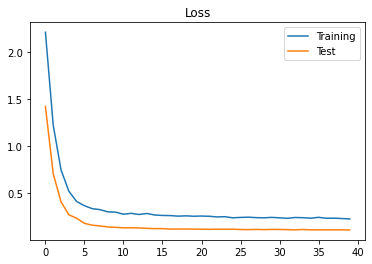

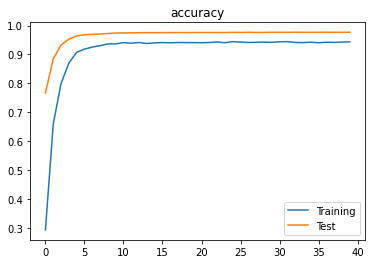

In [168]:
training_loop(40, 128)

In [169]:
# Run test
dset_test = NumpyDataset(x_test, y_test)
dload_test = torch.utils.data.dataloader.DataLoader(dset_test, batch_size=512, num_workers=6)

preds = []
true = []
model.eval()
with torch.no_grad():
    for x, y in tqdm(dload_test, desc='test'):
        pred = model(x.float().to(device))
        preds.append(to_numpy(pred))
        true.append(y)
        
preds = np.concatenate(preds, 0).argmax(axis=-1)
true = np.concatenate(true, 0)

In [170]:
# ours
print('test acc', score_fn(true, preds))

test acc 0.9770198874618787


In [171]:
# plt.hist(preds, bins=output_size * 2)
# plt.title("Model Predictions")
# plt.xticks(np.arange(output_size))
# plt.figure()
# plt.hist(true, bins=output_size * 2)
# plt.title("Targets")
# plt.xticks(np.arange(output_size))
# 1

In [172]:
import pandas as pd
import sklearn.metrics
import numpy as np

def classification_report(*args, **kwargs):
    out_df = pd.DataFrame(sklearn.metrics.classification_report(*args, **kwargs, output_dict=True)).T
    # Order cols
    out_df[["precision","recall","f1-score","support"]]  
    # Round
    out_df[["precision","recall","f1-score"]]= out_df[["precision","recall","f1-score"]].apply(lambda x: round(x,2))
    out_df[["support"]]= out_df[["support"]].apply(lambda x: x.astype(np.int))
    return out_df

In [173]:
# pred_baseline = np.roll(true, shift=shift_length)
# df_report = classification_report(true, pred_baseline, labels=range(len(encoder.classes_)), target_names=encoder.classes_)
# df_report[df_report.support>0]

,precision,recall,f1-score,support
Coal,0.93,0.93,0.93,100
Calcareous Cement,0.87,0.61,0.72,114
Cinerite,0.98,0.98,0.98,234
Argillaceous Limestone,0.96,0.96,0.96,1152
Limestone,0.98,0.98,0.98,734
Cross Bedded Sst,0.97,0.98,0.97,970
Silty Sand,0.97,0.97,0.97,522
Silty Shale,0.93,0.95,0.94,104
Marlstone,1.00,1.00,1.00,11861
Shaly Silt,0.94,0.94,0.94,2574


In [184]:
df_report = classification_report(true, preds, labels=range(len(encoder.classes_)), target_names=encoder.classes_)
df_report[df_report.support>0]

/home/wassname/anaconda/envs/deep_ml_curriculum/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wassname/anaconda/envs/deep_ml_curriculum/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Coal,0.93,0.93,0.93,100
Calcareous Cement,0.87,0.61,0.72,114
Cinerite,0.98,0.98,0.98,234
Argillaceous Limestone,0.96,0.96,0.96,1152
Limestone,0.98,0.98,0.98,734
Cross Bedded Sst,0.97,0.98,0.97,970
Silty Sand,0.97,0.97,0.97,522
Silty Shale,0.93,0.95,0.94,104
Marlstone,1.00,1.00,1.00,11861
Shaly Silt,0.94,0.94,0.94,2574


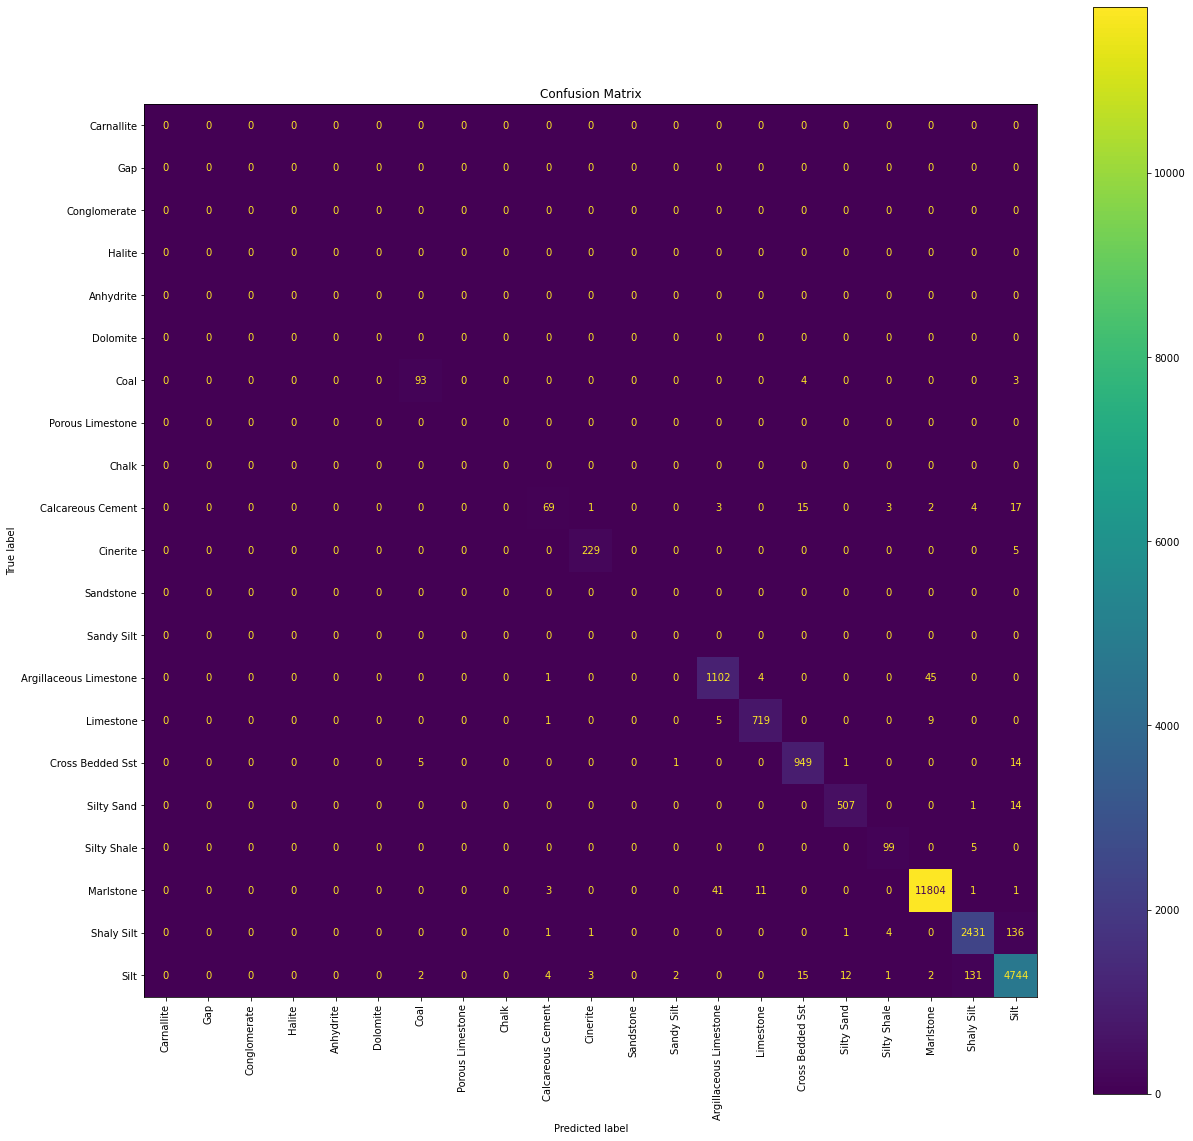

In [175]:
cm = sklearn.metrics.confusion_matrix(true, preds, labels=range(len(encoder.classes_)))

plt.figure(figsize=(20, 20))
plt.title('Confusion Matrix')
ax=plt.gca()
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=encoder.classes_)
disp.plot(ax=ax, xticks_rotation=90)
plt.show()

#### Well logs

In [176]:
well_name = "30_4-1"
logs = df.loc[well_name].sort_index()

In [177]:
x_test, y_test = get_sequences(logs)

x_test = torch.Tensor(x_test)#.to(device)
y_test = torch.LongTensor(y_test)#.to(device)

preds = to_numpy(model(x_test.to(device)).argmax(axis=-1))

In [178]:
df_log_results = logs.iloc[10:].copy()
df_log_results['pred'] = pd.Categorical(encoder.inverse_transform(preds), categories=df_log_results.LITHOLOGY_GEOLINK.values.categories)
df_log_results[['LITHOLOGY_GEOLINK', 'pred']]

,LITHOLOGY_GEOLINK,pred
DEPT,,
1909.65,Shaly Silt,Shaly Silt
1909.80,Silt,Shaly Silt
1909.95,Silt,Shaly Silt
1910.10,Silt,Silt
1910.25,Silt,Silt
...,...,...
5438.40,Cross Bedded Sst,Silt
5438.55,Cross Bedded Sst,Cross Bedded Sst
5438.70,Cross Bedded Sst,Cross Bedded Sst


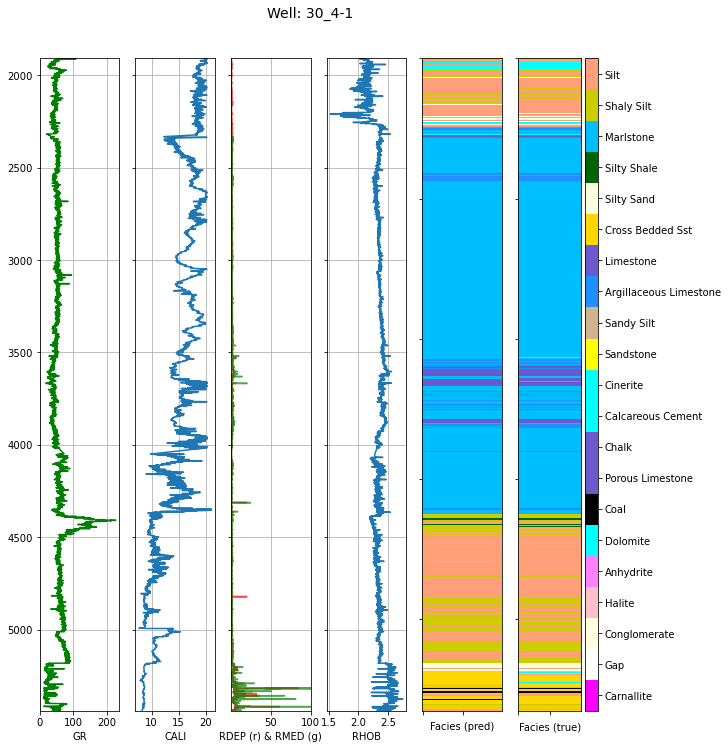

In [179]:
from deep_ml_curriculum.visualization.well_log import plot_well_pred
plot_well_pred(well_name, df_log_results,
               facies_true=df_log_results.LITHOLOGY_GEOLINK.values, 
               facies_pred=df_log_results.pred.values)
plt.show()

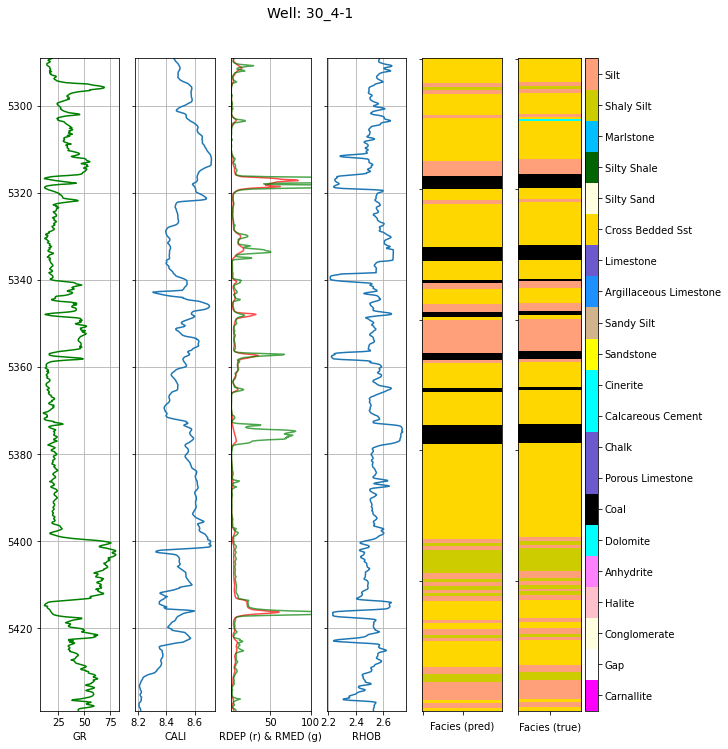

In [180]:
from deep_ml_curriculum.visualization.well_log import plot_well_pred
tail=1000
plot_well_pred(well_name, df_log_results.iloc[-tail:],
               facies_true=df_log_results.iloc[-tail:].LITHOLOGY_GEOLINK.values, 
               facies_pred=df_log_results.iloc[-tail:].pred.values)
plt.show()

As we saw in the previous examples the model requires training over 100s of epochs to reach the best results. However, in this example due to large size of dataset and the model we stopped after `10` epochs. Try increasing the number of epochs to see how it will affect the accuracy.<br>

Obviously the model right now is not performing well. But there are number ways we can improve it:
1. Training for longer. instead of stopping after `10` epochs go for longer.
2. Increase the hidden state size.
3. Increase the size of training data by adding data from more wells to training. 
4. Increase the size of the sequences so the model get to look further in the history.

#### Exercise 2
Try one of the options above to improve the model.

In [181]:
# Code Here

Let's have a look at model's predictions.

The distribution of data shows that the model is too focused on type `17` and `18` which is why we are having low accuracy.


<div class="alert alert-success">
    
### Solutions  
<details><summary>See solutions</summary>

<details><summary>Exercise 1</summary>
<b>Increase sequence length to 18</b>

```Python
seq_length = 18
x, y = create_seq_data(data,seq_length)
xtrain = x[:100,:,:]
ytrain = y[:100,:]
xtest = x[100:,:,:]
ytest = y[100:,:]
model = LSTM(1, 50, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_model(model, xtrain, ytrain, 500)
```
<b>Change model size to 100</b>
```Python
model = LSTM(1, 100, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_model(model, xtrain, ytrain, 500)
```

</details>
<details><summary>Exercise 2</summary>
    <b>Larger hidden size</b>
    
```Python
model = LSTM(
    input_size=len(feat_cols),
    hidden_size=400,
    num_layers=1,
    output_size=output_size,
).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
training_loop(10, 1024)
```

<b>Train longer</b>
    
```Python
model = LSTM(
    input_size=len(feat_cols),
    hidden_size=200,
    num_layers=1,
    output_size=output_size,
).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
training_loop(20, 1024)
```
 
</details>
</details>
</div>

## Further Reading
- [Introduction to RNN](http://slazebni.cs.illinois.edu/spring17/lec02_rnn.pdf)
- [A friendly introduction to Recurrent Neural Networks](https://www.youtube.com/watch?v=UNmqTiOnRfg)
- [Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)](https://www.youtube.com/watch?v=WCUNPb-5EYI&t=97s)
- [Introduction to LSTM](https://medium.com/x8-the-ai-community/a-7-minute-introduction-to-lstm-5e1480e6f52a)
- [LSTM and GRU](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)
- [Time Series Prediction with LSTM](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/)
- [Building RNN from scratch](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
